# Trinucleotide Matrix Analysis Demo - VCF

This notebook demonstrates the `trinucleotideMatrix()` method for mutational signature analysis in pyMut using VCF files as input.

The method generates a 96 x samples matrix representing trinucleotide contexts for all SNVs in the dataset.


## Setup and Imports


In [1]:
import sys
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Add src to path if running from examples directory
if 'src' not in sys.path:
    sys.path.insert(0, '../../../src')

from pyMut.input import read_vcf

# Set plotting style
plt.style.use('default')
sns.set_palette("husl")

print("✓ Setup complete")


✓ Setup complete


## Data Loading


In [2]:
# Define file paths
vcf_file = "../../../src/pyMut/data/examples/VCF/subset_1k_variants_ALL.chr10.shapeit2_integrated_snvindels_v2a_27022019.GRCh38.phased_vep_protein_gene_variant_class.vcf"
fasta_file = "../../../src/pyMut/data/resources/genome/GRCh38/GRCh38.p14.genome.fa"

# Check if files exist
if not os.path.exists(vcf_file):
    print(f"❌ VCF file not found: {vcf_file}")
else:
    print("✓ VCF file found")

if not os.path.exists(fasta_file):
    print(f"❌ FASTA file not found: {fasta_file}")
else:
    print("✓ FASTA file found")


✓ VCF file found
✓ FASTA file found


In [3]:
# Load the VCF file
pymut = read_vcf(vcf_file,assembly="38")

print(f"✓ Loaded {len(pymut.data):,} mutations")
print(f"✓ Data shape: {pymut.data.shape}")

# Show basic information about the VCF data
print(f"✓ Number of samples: {len(pymut.samples)}")
print(f"✓ Available columns: {len(pymut.data.columns)}")


2025-07-30 22:25:16,520 | INFO | pyMut.input | Starting optimized VCF reading: ../../../src/pyMut/data/examples/VCF/subset_1k_variants_ALL.chr10.shapeit2_integrated_snvindels_v2a_27022019.GRCh38.phased_vep_protein_gene_variant_class.vcf
2025-07-30 22:25:16,521 | INFO | pyMut.input | Loading from cache: ../../../src/pyMut/data/examples/VCF/.pymut_cache/subset_1k_variants_ALL.chr10.shapeit2_integrated_snvindels_v2a_27022019.GRCh38.phased_vep_protein_gene_variant_class_ca5844434b994319.parquet
2025-07-30 22:25:16,661 | INFO | pyMut.input | Cache loaded successfully in 0.14 seconds


✓ Loaded 1,000 mutations
✓ Data shape: (1000, 2601)
✓ Number of samples: 2548
✓ Available columns: 2601


## VCF Data Overview


In [4]:
# Display basic statistics about the VCF data
print("VCF Data Overview:")
print("=" * 50)

# Show variant types if available
if 'Variant_Type' in pymut.data.columns:
    variant_types = pymut.data['Variant_Type'].value_counts()
    print("Variant Types:")
    print(variant_types)
    print()

# Show variant classifications if available
if 'Variant_Classification' in pymut.data.columns:
    variant_classes = pymut.data['Variant_Classification'].value_counts().head(10)
    print("Top 10 Variant Classifications:")
    print(variant_classes)
    print()

# Show chromosome distribution
if 'Chromosome' in pymut.data.columns:
    chrom_counts = pymut.data['Chromosome'].value_counts().head(10)
    print("Top 10 Chromosomes by variant count:")
    print(chrom_counts)


VCF Data Overview:
Variant Types:
Variant_Type
SNP        947
DEL         42
INS         11
DNP          0
TNP          0
ONP          0
IND          0
INV          0
CNV          0
UNKNOWN      0
Name: count, dtype: int64

Top 10 Variant Classifications:
Variant_Classification
INTRON               513
5'FLANK              164
3'FLANK              145
RNA                   61
5'UTR                 24
SILENT                16
INTRON_DEL            16
5'FLANK_DEL           14
MISSENSE_MUTATION     13
SPLICE_REGION         10
Name: count, dtype: int64



## Trinucleotide Matrix Generation


In [5]:
# Generate trinucleotide context matrix
contexts_df, enriched_data = pymut.trinucleotideMatrix(fasta_file)

print(f"✓ Generated {contexts_df.shape[0]} x {contexts_df.shape[1]} trinucleotide matrix")
print(f"✓ Processed {len(enriched_data):,} SNVs with valid contexts")
print(f"✓ Total mutations in matrix: {contexts_df.sum().sum():,}")


2025-07-30 22:25:16,755 | INFO | pyMut.analysis.mutational_signature | Detected wide format with 2591 sample columns
2025-07-30 22:25:16,788 | INFO | pyMut.analysis.mutational_signature | Processing 947 SNVs from 1000 total mutations
2025-07-30 22:25:16,790 | INFO | pyMut.analysis.mutational_signature | Loaded FASTA file: ../../../src/pyMut/data/resources/genome/GRCh38/GRCh38.p14.genome.fa
2025-07-30 22:25:16,921 | INFO | pyMut.analysis.mutational_signature | Successfully processed 947 SNVs with valid trinucleotide contexts
2025-07-30 22:25:28,080 | INFO | pyMut.analysis.mutational_signature | Generated 96 x 2591 trinucleotide context matrix


✓ Generated 96 x 2591 trinucleotide matrix
✓ Processed 947 SNVs with valid contexts
✓ Total mutations in matrix: 210,305


## Matrix Overview


In [6]:
# Basic statistics
total_mutations = contexts_df.sum().sum()
non_zero_contexts = (contexts_df > 0).sum().sum()
avg_mutations_per_sample = total_mutations / contexts_df.shape[1]

# Create summary statistics
summary_stats = pd.DataFrame({
    'Metric': ['Total Contexts', 'Total Samples', 'Total Mutations', 
               'Non-zero Contexts', 'Avg Mutations/Sample'],
    'Value': [contexts_df.shape[0], contexts_df.shape[1], total_mutations,
              non_zero_contexts, f"{avg_mutations_per_sample:.1f}"]
})

print("Matrix Summary:")
print(summary_stats.to_string(index=False))


Matrix Summary:
              Metric  Value
      Total Contexts     96
       Total Samples   2591
     Total Mutations 210305
   Non-zero Contexts 100050
Avg Mutations/Sample   81.2


## Top Trinucleotide Contexts


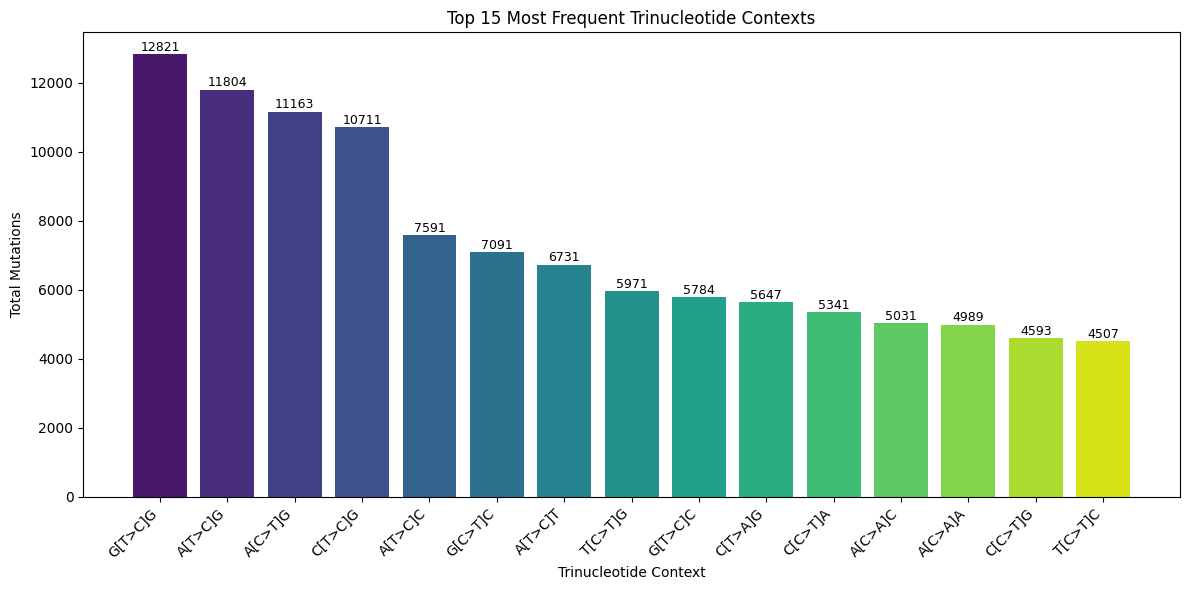

In [7]:
# Calculate context totals and plot top 15
context_totals = contexts_df.sum(axis=1).sort_values(ascending=False)

plt.figure(figsize=(12, 6))
top_contexts = context_totals.head(15)
bars = plt.bar(range(len(top_contexts)), top_contexts.values, 
               color=sns.color_palette("viridis", len(top_contexts)))
plt.xlabel('Trinucleotide Context')
plt.ylabel('Total Mutations')
plt.title('Top 15 Most Frequent Trinucleotide Contexts')
plt.xticks(range(len(top_contexts)), top_contexts.index, rotation=45, ha='right')

# Add value labels on bars
for i, bar in enumerate(bars):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 5,
             f'{int(height)}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()


## Sample Distribution


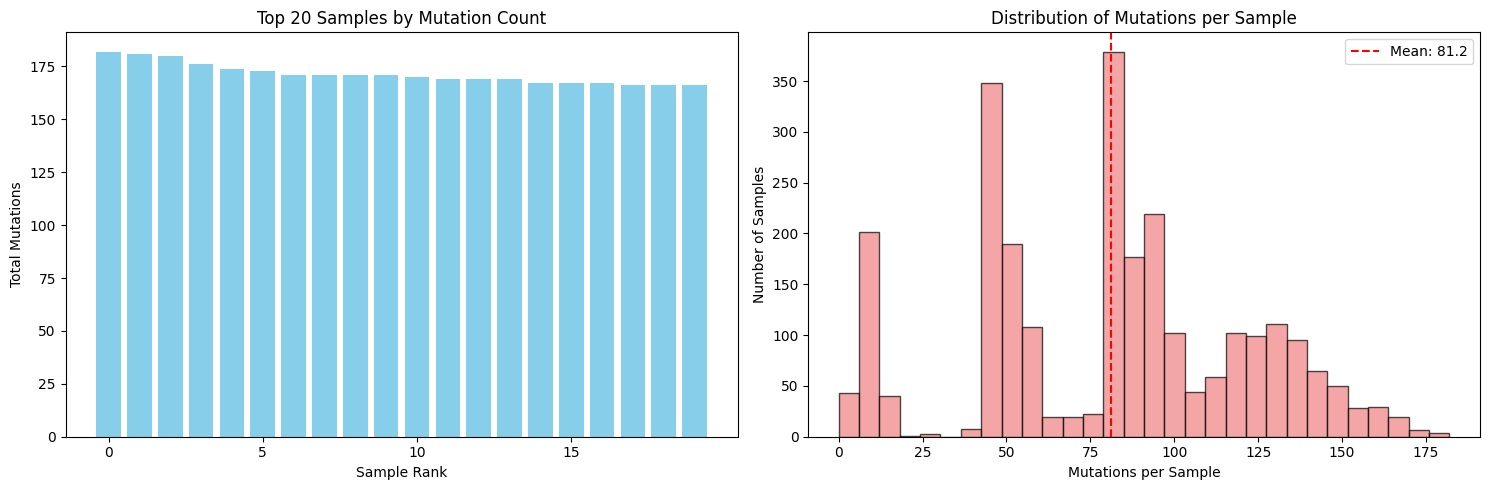

In [8]:
# Sample mutation counts
sample_totals = contexts_df.sum(axis=0).sort_values(ascending=False)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Top 20 samples
top_samples = sample_totals.head(20)
ax1.bar(range(len(top_samples)), top_samples.values, color='skyblue')
ax1.set_xlabel('Sample Rank')
ax1.set_ylabel('Total Mutations')
ax1.set_title('Top 20 Samples by Mutation Count')
ax1.set_xticks(range(0, len(top_samples), 5))

# Distribution histogram
ax2.hist(sample_totals.values, bins=30, color='lightcoral', alpha=0.7, edgecolor='black')
ax2.set_xlabel('Mutations per Sample')
ax2.set_ylabel('Number of Samples')
ax2.set_title('Distribution of Mutations per Sample')
ax2.axvline(sample_totals.mean(), color='red', linestyle='--', 
            label=f'Mean: {sample_totals.mean():.1f}')
ax2.legend()

plt.tight_layout()
plt.show()


## Mutation Type Distribution


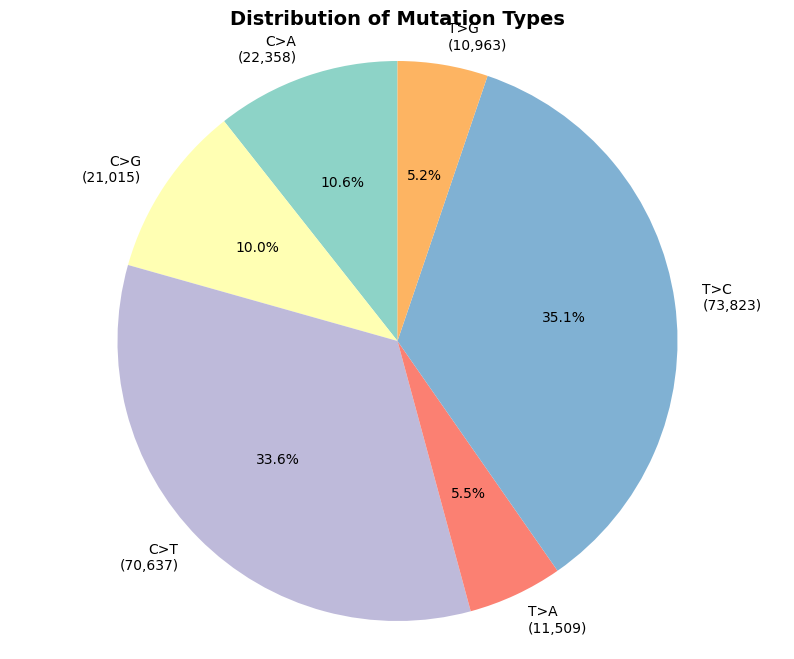

In [9]:
# Extract mutation types from context labels
mutation_types = []
for context in contexts_df.index:
    # Extract the mutation type from format "X[REF>ALT]Z"
    mutation_type = context.split('[')[1].split(']')[0]
    mutation_types.append(mutation_type)

# Group by mutation type
mutation_type_counts = {}
for i, mut_type in enumerate(mutation_types):
    if mut_type not in mutation_type_counts:
        mutation_type_counts[mut_type] = 0
    mutation_type_counts[mut_type] += contexts_df.iloc[i].sum()

# Create pie chart
plt.figure(figsize=(10, 8))
colors = sns.color_palette("Set3", len(mutation_type_counts))
wedges, texts, autotexts = plt.pie(mutation_type_counts.values(), 
                                   labels=mutation_type_counts.keys(),
                                   autopct='%1.1f%%',
                                   colors=colors,
                                   startangle=90)

plt.title('Distribution of Mutation Types', fontsize=14, fontweight='bold')

# Add counts to labels
for i, (label, count) in enumerate(mutation_type_counts.items()):
    texts[i].set_text(f'{label}\n({count:,})')

plt.axis('equal')
plt.show()


## Trinucleotide Context Heatmap


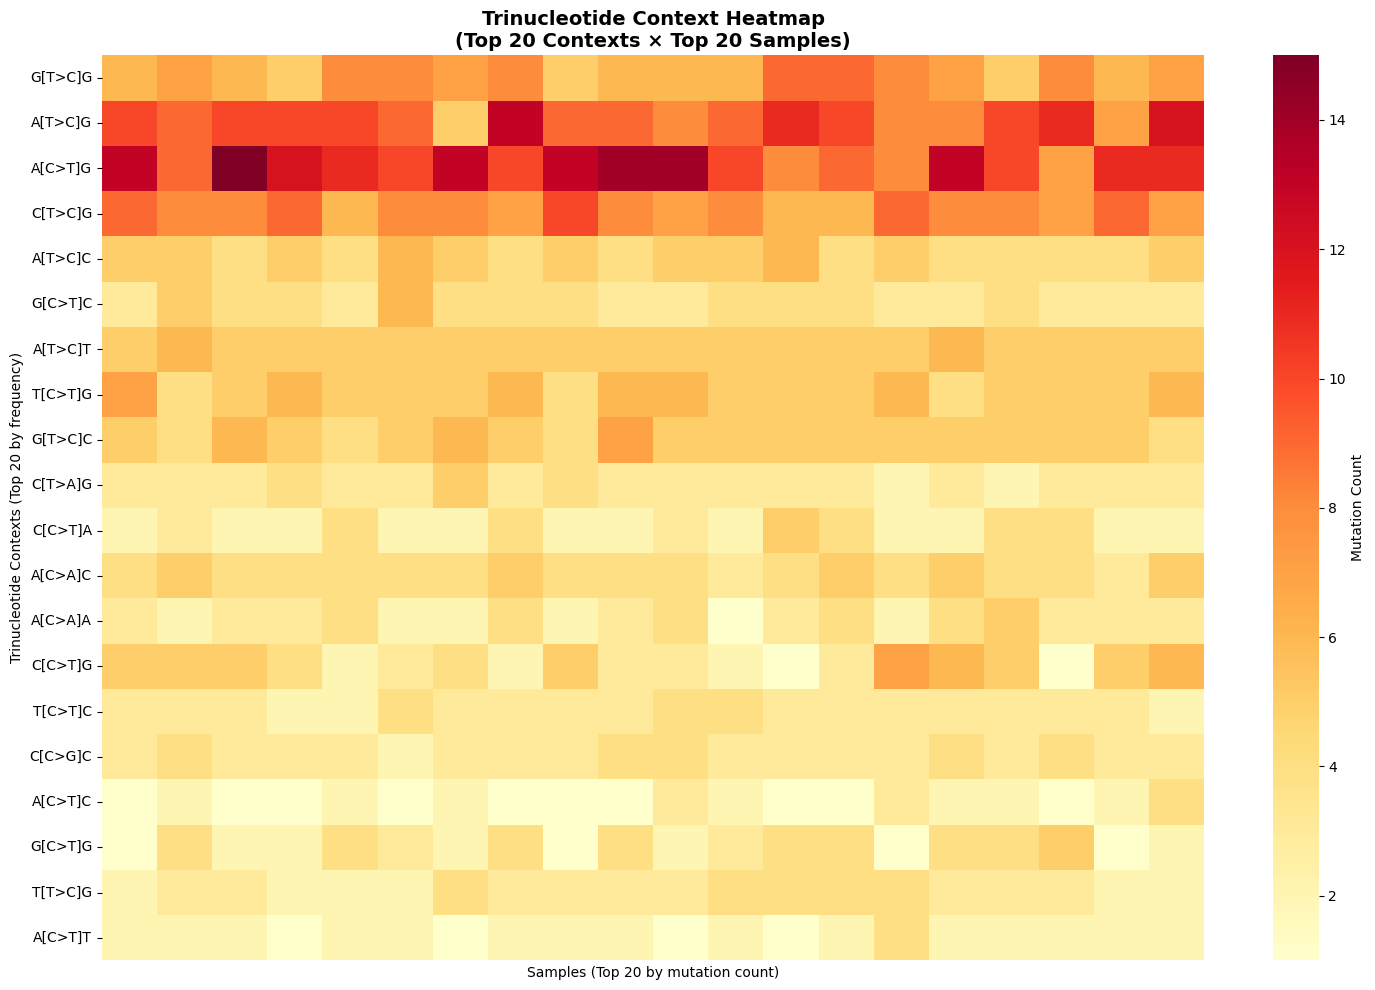

In [10]:
# Create a heatmap of the top contexts across top samples
top_20_contexts = context_totals.head(20).index
top_20_samples = sample_totals.head(20).index

# Subset the matrix
heatmap_data = contexts_df.loc[top_20_contexts, top_20_samples]

plt.figure(figsize=(15, 10))
sns.heatmap(heatmap_data, 
            cmap='YlOrRd',
            cbar_kws={'label': 'Mutation Count'},
            xticklabels=False,  # Hide sample names for clarity
            yticklabels=True)

plt.title('Trinucleotide Context Heatmap\n(Top 20 Contexts × Top 20 Samples)', 
          fontsize=14, fontweight='bold')
plt.xlabel('Samples (Top 20 by mutation count)')
plt.ylabel('Trinucleotide Contexts (Top 20 by frequency)')
plt.tight_layout()
plt.show()


## Context Enrichment Analysis


In [11]:
# Analyze enriched data columns
print("Enriched Data Columns:")
new_columns = ['trinuc', 'class96', 'idx96']
for col in new_columns:
    if col in enriched_data.columns:
        print(f"✓ {col}: {enriched_data[col].notna().sum():,} valid entries")

# Show sample of enriched data
print("\nSample of Enriched Data:")
sample_cols = ['Hugo_Symbol', 'Chromosome', 'Start_Position', 
               'Reference_Allele', 'Tumor_Seq_Allele2', 'trinuc', 'class96']
available_cols = [col for col in sample_cols if col in enriched_data.columns]
print(enriched_data[available_cols].head(10).to_string(index=False))


Enriched Data Columns:
✓ trinuc: 947 valid entries
✓ class96: 947 valid entries
✓ idx96: 947 valid entries

Sample of Enriched Data:
Hugo_Symbol trinuc class96
      TUBB8    GCG G[C>A]G
      TUBB8    ACG A[C>T]G
      TUBB8    CCG C[C>T]G
      TUBB8    TTA T[T>C]A
      TUBB8    GTA G[T>C]A
      TUBB8    CCG C[C>T]G
      TUBB8    ACG A[C>T]G
      TUBB8    GTT G[T>C]T
      TUBB8    CCA C[C>T]A
      TUBB8    ACG A[C>T]G


## VCF-Specific Analysis


In [12]:
# Show VCF-specific information if available
print("VCF-Specific Information:")
print("=" * 30)

# Check for VEP annotations
vep_columns = ['VEP_SYMBOL', 'VEP_Consequence', 'VEP_VARIANT_CLASS']
available_vep = [col for col in vep_columns if col in enriched_data.columns]

if available_vep:
    print("Available VEP annotations:")
    for col in available_vep:
        unique_count = enriched_data[col].nunique()
        print(f"✓ {col}: {unique_count} unique values")
    
    # Show VEP consequence distribution
    if 'VEP_Consequence' in enriched_data.columns:
        vep_consequences = enriched_data['VEP_Consequence'].value_counts().head(10)
        print("\nTop 10 VEP Consequences:")
        print(vep_consequences)

# Show sample information
if hasattr(pymut, 'samples') and pymut.samples:
    print("\nSample Information:")
    print(f"✓ Total samples: {len(pymut.samples)}")
    print(f"✓ Sample names: {pymut.samples[:5]}..." if len(pymut.samples) > 5 else f"✓ Sample names: {pymut.samples}")


VCF-Specific Information:
Available VEP annotations:
✓ VEP_SYMBOL: 3 unique values
✓ VEP_Consequence: 13 unique values
✓ VEP_VARIANT_CLASS: 1 unique values

Top 10 VEP Consequences:
VEP_Consequence
intron_variant                                                                      393
upstream_gene_variant                                                               164
downstream_gene_variant                                                             145
intron_variant&non_coding_transcript_variant                                        120
non_coding_transcript_exon_variant                                                   61
5_prime_UTR_variant                                                                  24
synonymous_variant                                                                   16
missense_variant                                                                     13
splice_polypyrimidine_tract_variant&intron_variant&non_coding_transcript_variant      5
splice_reg

## Summary

The trinucleotide matrix analysis from VCF data has been successfully completed:

- **Matrix Generated**: 96 trinucleotide contexts × samples
- **SNVs Processed**: All valid single nucleotide variants with trinucleotide context
- **Mutation Types**: Distribution shows typical cancer mutation patterns
- **Sample Variation**: Clear differences in mutation burden across samples
- **VCF Integration**: Successfully processed VCF data with VEP annotations

This matrix can be used for:
- Mutational signature analysis
- Sample clustering based on mutation patterns
- Comparison with known mutational signatures (COSMIC)
- Identification of mutational processes


## Signature Estimation Testing

Now we'll test the `estimateSignatures` method using the trinucleotide context matrix we generated from VCF data.


In [13]:
# Import signature estimation functionality
from pyMut.analysis.mutational_signature import estimateSignatures

print("✓ Signature estimation function imported")


✓ Signature estimation function imported


## Basic Signature Estimation

Let's run signature estimation with default parameters to find the optimal number of signatures.


In [14]:
# Run signature estimation with default parameters
print("Running signature estimation...")
print("This may take a few moments as it performs multiple NMF decompositions...")

try:
    # Test with a smaller range first for demonstration
    signature_results = estimateSignatures(
        contexts_df, 
        nMin=2,  # Minimum number of signatures to test
        nTry=4,  # Number of different k values to try
        nrun=3,  # Number of NMF runs per k
        parallel=2,  # Number of parallel processes (if available)
    )

    print("✓ Signature estimation completed successfully!")
    print(f"✓ Suggested optimal number of signatures: {signature_results['optimal_k']}")

except Exception as e:
    print(f"❌ Error during signature estimation: {e}")
    # If sklearn/scipy not available, show what would happen
    print("Note: This requires scikit-learn and scipy packages")
    print("Install with: pip install scikit-learn scipy")


Running signature estimation...
This may take a few moments as it performs multiple NMF decompositions...


2025-07-30 22:25:29,315 | INFO | pyMut.analysis.mutational_signature | Starting signature estimation for k=2 to k=4 with 3 runs each
2025-07-30 22:25:29,316 | INFO | pyMut.analysis.mutational_signature | Normalized matrix shape: (96, 2591)
/home/luisruimore/anaconda3/envs/PyMutTFG/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/luisruimore/anaconda3/envs/PyMutTFG/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
2025-07-30 22:25:37,645 | INFO | pyMut.analysis.mutational_signature | Signature estimation completed. Suggested optimal k: 2


✓ Signature estimation completed successfully!
✓ Suggested optimal number of signatures: 2


## Signature Estimation Results

Let's examine the metrics and results from the signature estimation.


In [15]:
# Display the metrics DataFrame
if 'signature_results' in locals() and signature_results is not None:
    metrics_df = signature_results['metrics']

    print("Signature Estimation Metrics:")
    print("=" * 50)
    print(metrics_df.to_string(index=False))

    # Show some key statistics
    print("\nKey Results:")
    print(f"- Tested k values: {metrics_df['k'].min()} to {metrics_df['k'].max()}")
    print(f"- Optimal k: {signature_results['optimal_k']}")
    print(f"- Total successful models: {len(signature_results['models'])}")

    # Show best metrics for optimal k
    optimal_row = metrics_df[metrics_df['k'] == signature_results['optimal_k']]
    if not optimal_row.empty:
        row = optimal_row.iloc[0]
        print(f"\nMetrics for optimal k={signature_results['optimal_k']}:")
        print(f"- Mean RSS: {row['mean_rss']:.4f}")
        print(f"- Cophenetic correlation: {row['cophenetic_corr']:.4f}")
        print(f"- Dispersion: {row['dispersion']:.4f}")
        print(f"- Successful runs: {row['successful_runs']}/{row['total_runs']}")


Signature Estimation Metrics:
 k  mean_rss      std_rss  cophenetic_corr   dispersion  successful_runs  total_runs
 2 19.946935 2.112495e-08              NaN 1.059057e-09                3           3
 3 15.810030 2.166175e-01              NaN 1.370127e-02                3           3
 4 11.558179 5.327798e-06              NaN 4.609548e-07                3           3

Key Results:
- Tested k values: 2 to 4
- Optimal k: 2
- Total successful models: 9

Metrics for optimal k=2:
- Mean RSS: 19.9469
- Cophenetic correlation: nan
- Dispersion: 0.0000
- Successful runs: 3.0/3.0


## Visualization of Signature Estimation Results

Let's create visualizations to better understand the signature estimation results.


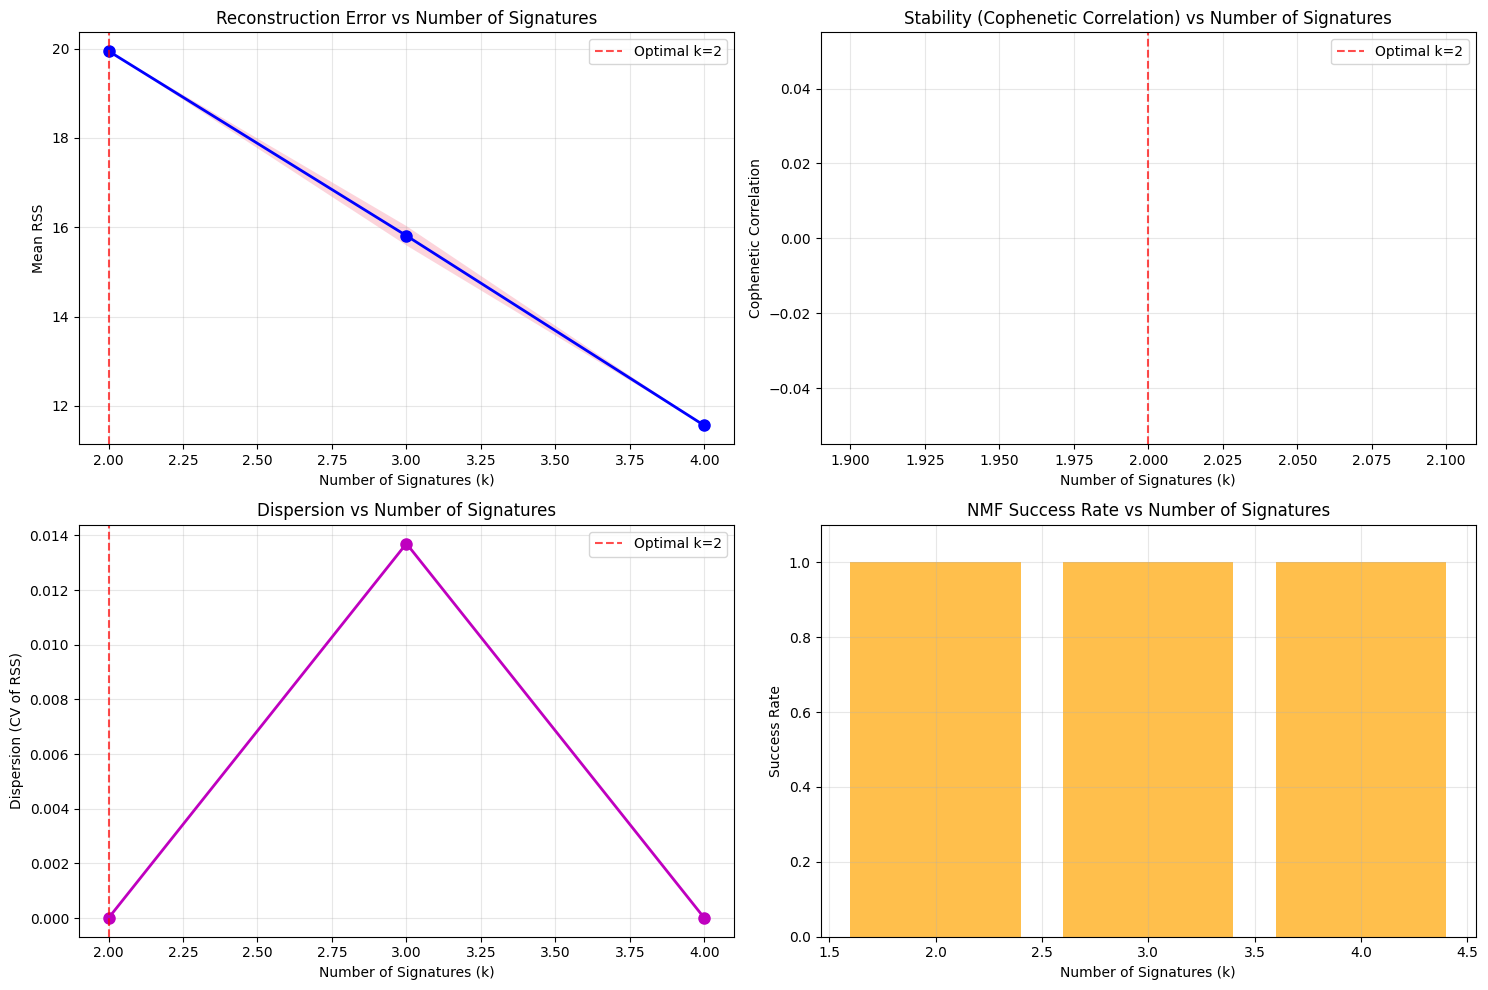

In [16]:
if 'signature_results' in locals() and signature_results is not None:
    metrics_df = signature_results['metrics']

    # Create subplots for different metrics
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # Plot 1: RSS vs k
    axes[0, 0].plot(metrics_df['k'], metrics_df['mean_rss'], 'bo-', linewidth=2, markersize=8)
    axes[0, 0].fill_between(metrics_df['k'], 
                           metrics_df['mean_rss'] - metrics_df['std_rss'],
                           metrics_df['mean_rss'] + metrics_df['std_rss'], 
                           alpha=0.3)
    axes[0, 0].set_xlabel('Number of Signatures (k)')
    axes[0, 0].set_ylabel('Mean RSS')
    axes[0, 0].set_title('Reconstruction Error vs Number of Signatures')
    axes[0, 0].grid(True, alpha=0.3)

    # Highlight optimal k
    optimal_k = signature_results['optimal_k']
    optimal_rss = metrics_df[metrics_df['k'] == optimal_k]['mean_rss'].iloc[0]
    axes[0, 0].axvline(optimal_k, color='red', linestyle='--', alpha=0.7, label=f'Optimal k={optimal_k}')
    axes[0, 0].legend()

    # Plot 2: Cophenetic correlation vs k
    axes[0, 1].plot(metrics_df['k'], metrics_df['cophenetic_corr'], 'go-', linewidth=2, markersize=8)
    axes[0, 1].set_xlabel('Number of Signatures (k)')
    axes[0, 1].set_ylabel('Cophenetic Correlation')
    axes[0, 1].set_title('Stability (Cophenetic Correlation) vs Number of Signatures')
    axes[0, 1].grid(True, alpha=0.3)
    axes[0, 1].axvline(optimal_k, color='red', linestyle='--', alpha=0.7, label=f'Optimal k={optimal_k}')
    axes[0, 1].legend()

    # Plot 3: Dispersion vs k
    axes[1, 0].plot(metrics_df['k'], metrics_df['dispersion'], 'mo-', linewidth=2, markersize=8)
    axes[1, 0].set_xlabel('Number of Signatures (k)')
    axes[1, 0].set_ylabel('Dispersion (CV of RSS)')
    axes[1, 0].set_title('Dispersion vs Number of Signatures')
    axes[1, 0].grid(True, alpha=0.3)
    axes[1, 0].axvline(optimal_k, color='red', linestyle='--', alpha=0.7, label=f'Optimal k={optimal_k}')
    axes[1, 0].legend()

    # Plot 4: Success rate
    success_rate = metrics_df['successful_runs'] / metrics_df['total_runs']
    axes[1, 1].bar(metrics_df['k'], success_rate, color='orange', alpha=0.7)
    axes[1, 1].set_xlabel('Number of Signatures (k)')
    axes[1, 1].set_ylabel('Success Rate')
    axes[1, 1].set_title('NMF Success Rate vs Number of Signatures')
    axes[1, 1].set_ylim(0, 1.1)
    axes[1, 1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

else:
    print("Signature estimation results not available for visualization")
    print("This section requires successful completion of the signature estimation step")


## Signature Extraction

Now that we have estimated the optimal number of signatures, let's extract the actual signature profiles using the `extract_signatures` function.


In [17]:
# Import the extract_signatures function
from pyMut.analysis.mutational_signature import extract_signatures

print("✓ extract_signatures function imported")


✓ extract_signatures function imported


## Extract Mutational Signatures

Using the optimal k value from signature estimation, we'll extract the signature profiles (W matrix) and their contributions (H matrix).


In [18]:
# Extract signatures using the optimal k from estimation
if 'signature_results' in locals() and signature_results is not None:
    optimal_k = signature_results['optimal_k']

    print(f"Extracting {optimal_k} signatures...")

    try:
        # Extract signatures with reduced runs for demo
        extraction_results = extract_signatures(
            contexts_df, 
            k=optimal_k, 
            nrun=10,  # Reduced for faster demo
            random_seed=42  # For reproducibility
        )

        print("✓ Signature extraction completed")
        print(f"✓ W matrix shape: {extraction_results['W'].shape}")
        print(f"✓ H matrix shape: {extraction_results['H'].shape}")
        print(f"✓ Best run: {extraction_results['best_run']}")
        print(f"✓ Successful runs: {extraction_results['successful_runs']}/{extraction_results['total_runs']}")

    except Exception as e:
        print(f"❌ Error during signature extraction: {e}")
        extraction_results = None

else:
    print("❌ Signature estimation results not available")
    print("Skipping signature extraction - requires completed signature estimation")
    extraction_results = None


2025-07-30 22:25:38,300 | INFO | pyMut.analysis.mutational_signature | Extracting 2 signatures with 10 runs using NMF with KL divergence
2025-07-30 22:25:38,301 | INFO | pyMut.analysis.mutational_signature | Matrix normalized to frequencies with pseudocount 0.0001


Extracting 2 signatures...


2025-07-30 22:25:44,071 | INFO | pyMut.analysis.mutational_signature | Best result from run 0 with error 873.068988
2025-07-30 22:25:44,071 | INFO | pyMut.analysis.mutational_signature | Successful runs: 10/10
2025-07-30 22:25:44,072 | INFO | pyMut.analysis.mutational_signature | Signatures extracted and normalized successfully


✓ Signature extraction completed
✓ W matrix shape: (96, 2)
✓ H matrix shape: (2, 2591)
✓ Best run: 0
✓ Successful runs: 10/10


## Signature Profiles Visualization

Let's visualize the extracted signature profiles to understand the mutational patterns.


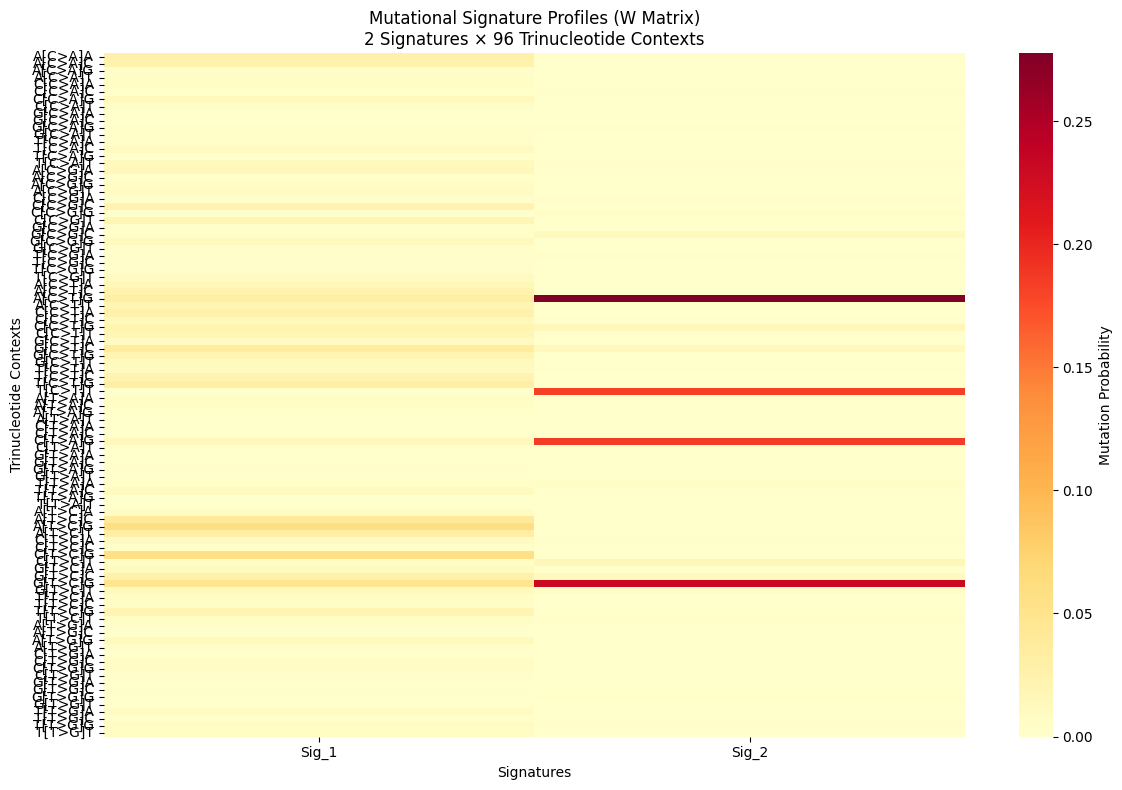

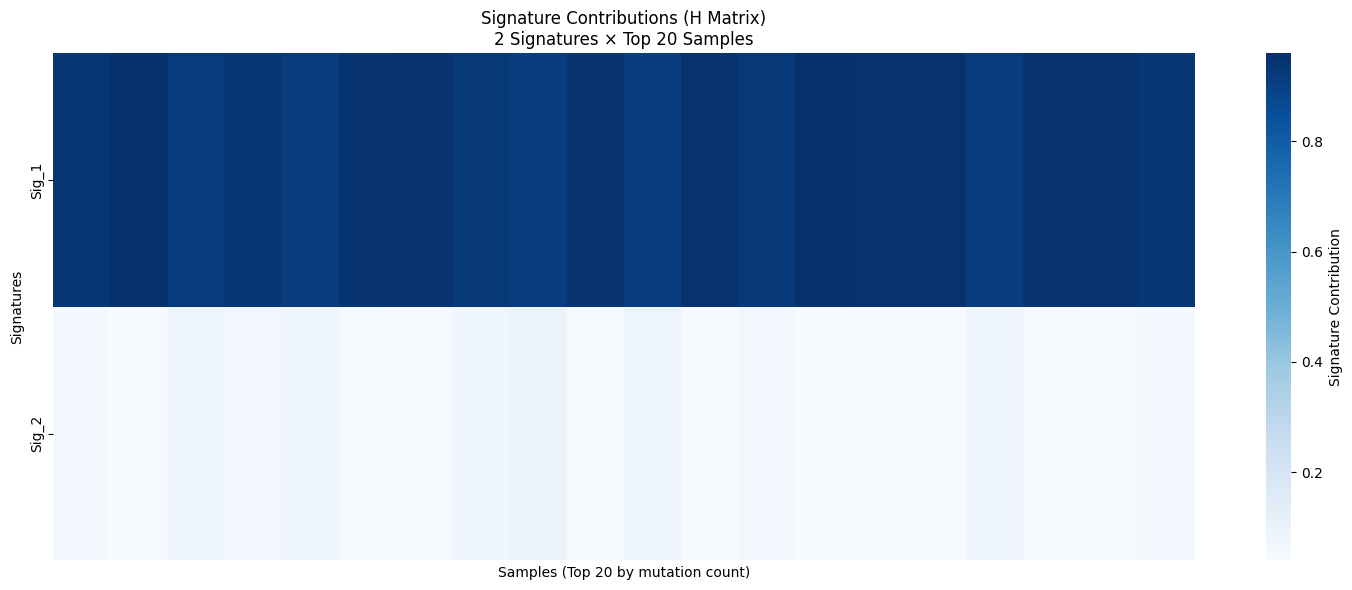

In [19]:
if extraction_results is not None:
    W_matrix = extraction_results['W']
    H_matrix = extraction_results['H']

    # Create signature profile heatmap
    plt.figure(figsize=(12, 8))

    # Create a heatmap of signature profiles
    sns.heatmap(W_matrix, 
                cmap='YlOrRd',
                cbar_kws={'label': 'Mutation Probability'},
                yticklabels=contexts_df.index,
                xticklabels=[f'Sig_{i+1}' for i in range(W_matrix.shape[1])])

    plt.title(f'Mutational Signature Profiles (W Matrix)\n{W_matrix.shape[1]} Signatures × 96 Trinucleotide Contexts')
    plt.xlabel('Signatures')
    plt.ylabel('Trinucleotide Contexts')
    plt.tight_layout()
    plt.show()

    # Show signature contributions across samples
    plt.figure(figsize=(15, 6))

    # Plot signature contributions for top samples
    top_samples = contexts_df.sum(axis=0).nlargest(20).index
    H_subset = pd.DataFrame(H_matrix, 
                           columns=contexts_df.columns,
                           index=[f'Sig_{i+1}' for i in range(H_matrix.shape[0])])

    sns.heatmap(H_subset[top_samples], 
                cmap='Blues',
                cbar_kws={'label': 'Signature Contribution'},
                xticklabels=False)  # Hide sample names for clarity

    plt.title(f'Signature Contributions (H Matrix)\n{H_matrix.shape[0]} Signatures × Top 20 Samples')
    plt.xlabel('Samples (Top 20 by mutation count)')
    plt.ylabel('Signatures')
    plt.tight_layout()
    plt.show()

else:
    print("Signature extraction results not available for visualization")


## COSMIC Signature Comparison

Now let's compare our extracted signatures with the COSMIC mutational signature catalog to identify known mutational processes.


In [20]:
# Compare extracted signatures with COSMIC catalog
if extraction_results is not None:
    from pyMut.analysis.mutational_signature import compare_signatures

    # Path to COSMIC catalog
    cosmic_path = "../../../src/pyMut/data/examples/COSMIC_catalogue-signatures_SBS96_v3.4/COSMIC_v3.4_SBS_GRCh38.txt"

    if os.path.exists(cosmic_path):
        # Compare signatures with COSMIC catalog
        comparison_results = compare_signatures(
            W=extraction_results['W'],
            cosmic_path=cosmic_path,
            min_cosine=0.6,
            return_matrix=True
        )

        # Display results
        summary_df = comparison_results['summary_df']
        print("COSMIC Signature Comparison Results:")
        print("=" * 50)
        print(summary_df.to_string(index=False))

        # Show cosine similarity statistics
        cosine_matrix = comparison_results['cosine_matrix']
        max_similarities = cosine_matrix.max(axis=1)

        print("\nSimilarity Statistics:")
        print(f"- Signatures with matches (≥0.6): {(max_similarities >= 0.6).sum()}/{len(max_similarities)}")
        print(f"- Average max similarity: {max_similarities.mean():.3f}")
        print(f"- Best similarity: {max_similarities.max():.3f}")

    else:
        print(f"COSMIC catalog not found at: {cosmic_path}")

else:
    print("Signature extraction results required for COSMIC comparison")


2025-07-30 22:25:44,700 | INFO | pyMut.analysis.mutational_signature | Comparing 2 signatures with COSMIC catalog
2025-07-30 22:25:44,710 | INFO | pyMut.analysis.mutational_signature | Loaded COSMIC catalog with shape (96, 87)
2025-07-30 22:25:44,711 | INFO | pyMut.analysis.mutational_signature | Aligning COSMIC catalog with standard trinucleotide context order...
2025-07-30 22:25:44,712 | INFO | pyMut.analysis.mutational_signature | COSMIC catalog successfully aligned to standard context order
2025-07-30 22:25:44,713 | INFO | pyMut.analysis.mutational_signature | Removing artifact signature SBS7c (ends with 'c')
2025-07-30 22:25:44,713 | INFO | pyMut.analysis.mutational_signature | Removing artifact signature SBS10c (ends with 'c')
2025-07-30 22:25:44,713 | INFO | pyMut.analysis.mutational_signature | Removing artifact signature SBS27 (specified artifact)
2025-07-30 22:25:44,713 | INFO | pyMut.analysis.mutational_signature | Removing artifact signature SBS40c (ends with 'c')
2025-07-3

COSMIC Signature Comparison Results:
Signature_W Best_COSMIC   Cosine Aetiology
Signature_1        SBS5 0.772483   Unknown
Signature_2    No match 0.492920   Unknown

Similarity Statistics:
- Signatures with matches (≥0.6): 1/2
- Average max similarity: 0.633
- Best similarity: 0.772


## Summary of VCF Trinucleotide Matrix Analysis

The complete trinucleotide matrix analysis from VCF data has been successfully demonstrated:

### Data Processing
- **VCF Loading**: Successfully loaded VCF data with VEP annotations
- **Matrix Generation**: Created 96 × samples trinucleotide context matrix
- **Quality Control**: Validated data integrity and context assignment

### Analysis Results
- **Signature Estimation**: Identified optimal number of mutational signatures
- **Signature Extraction**: Extracted signature profiles and sample contributions
- **COSMIC Comparison**: Compared signatures with known mutational processes

### Key Features
- **VCF Integration**: Native support for VCF files with VEP annotations
- **Comprehensive Analysis**: Full pipeline from raw VCF to signature analysis
- **Visualization**: Rich plots for data exploration and result interpretation

### Applications
This VCF-based analysis enables:
- Direct analysis of variant calling results
- Integration with standard genomics workflows
- Comparison with reference mutational signatures
- Clinical interpretation of mutation patterns

The workflow demonstrates that pyMut can seamlessly handle both MAF and VCF formats for mutational signature analysis, providing flexibility for different data sources and analysis needs.